<a href="https://colab.research.google.com/github/NISHANTH-PAPARAJU/SpringBoard/blob/main/99-CapstoneProject/03-AGNewsClassification/AGNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AG News Classication

Steps:
  1. Exploratory Data Analysis (EDA)
  2. Data Preprocessing
  3. Decide Strategy
  4. Generate Word Embeddings (TFIDF, Word2Vec)
  5. Evaluate the Best model (ML models, LSTM, Transformers) on Data Subset. (Metric - Accuracy)
  6. Tuning the Best Model
  7. Pickle the models for future use
  8. Predictions


## 1.Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import time
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec

Open Readme & Classes Files and read through them.

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/readme.txt', 'r') as f:
  readme = f.read()
with open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/classes.txt', 'r') as f:
  classes = f.read()

In [4]:
readme

'AG\'s News Topic Classification Dataset\n\nVersion 3, Updated 09/09/2015\n\n\nORIGIN\n\nAG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .\n\nThe AG\'s news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. 

In [5]:
classes

'World\nSports\nBusiness\nSci/Tech\n'

In [6]:
labels = classes.split(sep='\n')
labels.pop() #Removing the Empty item at the last
labels

['World', 'Sports', 'Business', 'Sci/Tech']

> **Inferences**:
>*   There are 4 classes/labels ('World', 'Sports', 'Business', 'Sci Tech')



### Load the dataset

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/train.csv', names=['Category', 'HeadLine', 'Short Description'])
train_df.head()

,Category,HeadLine,Short Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [8]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/test.csv',names=['Category', 'HeadLine', 'Short Description'])
test_df.head()

,Category,HeadLine,Short Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


### Dataset count analysis

In [9]:
print(f'Training Data: {train_df.shape} | Testing Data: {test_df.shape}')

Training Data: (120000, 3) | Testing Data: (7600, 3)


In [10]:
train_df['Category'].value_counts()

4    30000
3    30000
2    30000
1    30000
Name: Category, dtype: int64

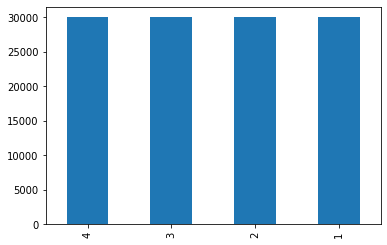

In [11]:
train_df['Category'].value_counts().plot(kind='bar')

In [12]:
test_df['Category'].value_counts()

3    1900
2    1900
1    1900
4    1900
Name: Category, dtype: int64

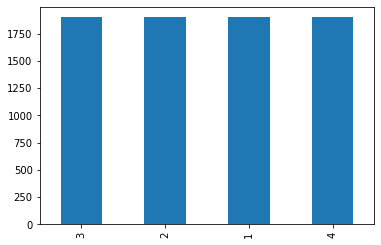

In [13]:
test_df['Category'].value_counts().plot(kind='bar')

> **Inferences**:
> * The training dataset consists of 120000 samples, with a well balanced class size of 30000 samples per class.
* The test dataset consists of 7600 Samples, with a well balanced class size of 1900 samples per class.
* In the real world problem it is highly unlikely to get a such well balanced data. However, the multi class classification (4 classes) is more closer to the real world problems.

### Visual Analysis of News Articles

#### Short Descriptions

In [14]:
train_df.iloc[0][2]

"Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [15]:
train_df.iloc[500][2]

"AP - Democratic presidential candidate John Kerry does not plan to visit Florida in the aftermath of Hurricane Charley because he's concerned his campaign entourage could distract from recovery efforts, he said Saturday."

In [16]:
train_df.iloc[2121][2]

'IN a desperate attempt to spark some public interest in an England team that appears to be quickly losing its appeal, Sven-Gran Eriksson announced his starting line-up for the friendly against Ukraine at St James #39; Park a day earlier than expected. '

In [17]:
train_df.iloc[12121][2]

" UNITED NATIONS (Reuters) - Days before a U.N. deadline for  Sudan to disarm and prosecute those responsible for violence in  the country's Darfur region, nations are looking to the African  Union rather than any U.N. sanctions to curb further killing."

In [18]:
train_df.iloc[32323][2]

'Terry Francona deployed three Gold Glove winners in his infield for the first time yesterday at Yankee Stadium in hope that their defensive expertise would aid the cause of sinkerball pitcher Derek Lowe stats, news.'

#### Headlines

In [19]:
train_df.iloc[0][1]

'Wall St. Bears Claw Back Into the Black (Reuters)'

In [20]:
train_df.iloc[500][1]

'Kerry Campaign Helping With Fla. Recovery (AP)'

In [21]:
train_df.iloc[2121][1]

'Are England fans are changing their Toon?'

In [22]:
train_df.iloc[12121][1]

'African Union Force Seen as Main Hope for Darfur'

In [23]:
train_df.iloc[32323][1]

'Lowe throws stinker, Yanks turn it around: Red Sox #39; momentum &lt;b&gt;...&lt;/b&gt;'

> **Inferences**:
> * It looks that the starting words in Short Descriptions and last word in headlines is related to the news agency that the news article is taken from. But this is inconsistant, so cannot be removed.
* There are common punctuations and stopwords which could be removed.

## 2.Data Preprocessing

### Function to Clean Text

In [24]:
def clean_corpus(corpus, tocase='lower', remove_punc=True, punctuations=list(string.punctuation), remove_whitespace =True,
                 stopwords=stop_words, remove_numbers=True, remove_urls=True, lemmatize=False):
    """
    Takes the corpus as input and performs the corpus cleaning as required,
    then returns the detokenized corpus.
    """
    cleaned_corpus = corpus
    # Tokenize
    tokens = word_tokenize(corpus)
    
    #Convert Multi Lingual Text
    # will be done later
    
    # Convert the corpus to one case (lower or Upper)
    valid_tokens = [token.lower() for token in tokens]
    
    # Remove Punctuations
    if remove_punc:
        valid_tokens = [token for token in valid_tokens if token not in punctuations]
    
    # Remove White Space
        # will be done later
        
    # Remove Other Special Characters.
    if remove_numbers:
        valid_tokens = [token for token in valid_tokens if re.search('[0-9]+', token) is None]
    
    # Remove urls.
    if remove_urls:
        valid_tokens = [token for token in valid_tokens if re.search('https+|http+', token) is None]
    
    # Remove stop words
    valid_tokens = [token for token in valid_tokens if token not in stop_words]
    
    #lemmatization / stemming
    if lemmatize:
        word_lem = WordNetLemmatizer()
        valid_tokens = [word_lem.lemmatize(token) for token in valid_tokens]
    else:
        pst = PorterStemmer()
        valid_tokens = [pst.stem(token) for token in valid_tokens]
    
    # De-tokenize
    cleaned_corpus = "".join([" "+i if not i.startswith("'") and i not in '!%\'()*+,-./:;<=>?@[\\]^_`{|}~'
                              else i for i in valid_tokens]).strip()
    return cleaned_corpus
    

In [25]:
clean_corpus(train_df.iloc[32323][1])

'low throw stinker yank turn around red sox momentum lt b gt ... lt /b gt'

### Apply the function on the data

In [26]:
start = time.time()
train_df['Clean Headline'] = train_df['HeadLine'].apply(lambda row: clean_corpus(row,lemmatize=True))
train_df['Clean Description'] = train_df['Short Description'].apply(lambda row: clean_corpus(row,lemmatize=True))
train_df['Clean Clubbed Article'] = train_df['Clean Headline'] + " " + train_df['Clean Description']
end = time.time()
print('Time Taken for processiong: ', (start - end))

Time Taken for processiong:  -81.59591484069824


In [27]:
start = time.time()
test_df['Clean Headline'] = test_df['HeadLine'].apply(lambda row: clean_corpus(row,lemmatize=True))
test_df['Clean Description'] = test_df['Short Description'].apply(lambda row: clean_corpus(row,lemmatize=True))
test_df['Clean Clubbed Article'] = test_df['Clean Headline'] + " " + test_df['Clean Description']
end = time.time()
print('Time Taken for processiong: ', (end - start), ' secs')

Time Taken for processiong:  5.094951629638672  secs


## 3.Decide Strategy

In [28]:
clubbed_articles = train_df['Clean Clubbed Article'].apply(lambda art: len(word_tokenize(art)))

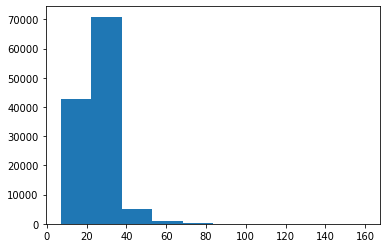

In [29]:
plt.hist(clubbed_articles, bins=10);

In [30]:
print("maximum no of words in Clubbed article (training data): ", max(clubbed_articles))
print("minimum no of words in Clubbed article (training data): ", min(clubbed_articles))

maximum no of words in Clubbed article (training data):  160
minimum no of words in Clubbed article (training data):  7


>**Inferences:**
>* Minimum no of words is 7 and the maximum number of words is 160, so there are no empty dataset and the maximum number is also well with in limits of 512 words to apply transformers.
* As the clubbed article (clubbing Headline and Description) is well within limits. We can make use of the clubbed article for training our model.
* Stategy:
  - Take Headline & Description as input
  - Clean the articles and club them together
  - perform word embedding (using w2v/Glove/fasttest)
  - Take a subset of data from the training set.
  - Evaluate different models on this subset.
  - pick the best model and then do training of the entire dataset.



## 4.Generate Word Embeddings (TFIDF, Word2Vec)

### TFIDF

In [31]:
def vectorize(vec, X_train, X_test):
    print("Vectorization Started...........")
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    print("Vectorization Completed.")
    return X_train_vec, X_test_vec, vec

In [32]:
def transform_X(vec, X_):
    X_trans = vec.transform(X_)
    return X_trans

In [33]:
X_train = train_df['Clean Clubbed Article']
y_train = train_df['Category']

X_test = test_df['Clean Clubbed Article']
y_test = test_df['Category']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120000,), (120000,), (7600,), (7600,))

In [34]:
tfidf = TfidfVectorizer()

X_train_tfidf, X_test_tfidf, tfidf_vec = vectorize(TfidfVectorizer(), X_train, X_test)

Vectorization Started...........
Vectorization Completed.


#### Document Term Matrix

In [35]:
# Unable to process as entire data at once as it is crashing the system due to limited RAM.
pd.DataFrame(X_train_tfidf[:5].toarray(), columns=tfidf_vec.get_feature_names())

,_but,_december,_new,_not,_nov,_top,aa,aaa,aac,aacb,aachen,aai,aaii,aal,aalborg,aaliyah,aap,aapl,aapt,aarde,aardsma,aaron,aarp,aarrett,aasketball,aathar,aattacks,aau,ab,aba,ababa,abacha,abaco,abagnale,abakus,abandon,abandoned,abandoning,abandonment,abare,...,zoran,zorba,zorilla,zoroastrianism,zos,zotinca,zovko,zoysa,zpl,zseries,zsuzsanna,zte,ztl,zu,zubrin,zucchini,zuckerman,zuhua,zukauskas,zulf,zuloaga,zuma,zundel,zuo,zurab,zurich,zurine,zvezda,zviadauri,zvidauri,zvonareva,zwick,zwiki,zydrunas,zygmunt,zyman,zyprexa,zz,zzz,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


>**Inferences**:
>* As we can notice the embeddings generated with tfidf has a lot of sparcity (lot of 0's in the matrix) and it is not expected to perform well with this embedding.


### Word2Vec

In [36]:
X_train_w2v = X_train.apply(word_tokenize)
X_train_w2v.iloc[:5]

0    [wall, st., bear, claw, back, black, reuters, ...
1    [carlyle, look, toward, commercial, aerospace,...
2    [oil, economy, cloud, stock, outlook, reuters,...
3    [iraq, halt, oil, export, main, southern, pipe...
4    [oil, price, soar, all-time, record, posing, n...
Name: Clean Clubbed Article, dtype: object

In [37]:
feature_size = 300
context_window = 5
min_count = 1
n_iter = 200
down_sample = 0.001
w2v = word2vec.Word2Vec(X_train_w2v, size=feature_size, window=context_window, min_count= min_count,
                        iter=n_iter, sample=down_sample)
vocab_w2v = w2v.wv.vocab.keys()

In [38]:
print("Time Taken to vectorize-Stem(secs): ", w2v.total_train_time)
print("Length of word vocab (stem): ", len(vocab_w2v))

Time Taken to vectorize-Stem(secs):  1763.2245570170373
Length of word vocab (stem):  82648


#### Define Functions for Embeddings Generations

In [39]:
def get_aggreagated_embedding(doc, model):
    """
    Takes the normalized-tokenized corpus as input and
    returns the average embeddings of document usingnp the model. (Averages the word embeddings)
    """
    vocab = model.wv.vocab.keys()
    doc_embed = np.average([model.wv[word.lower()] for word in doc if word.lower() in vocab], axis=0)
    return doc_embed

In [40]:
def document_vectorizer(corpus, w2v_model, doc_action='clean_tokenize', lemmatize=False):
    """
    Takes the list of documents (corpus), w2v_model as input
    Returns the document embeddings averaged on each word.
    
    Attributes:
      doc_action:  possible values ('clean_tokenize', 'tokenize', 'no_action')
                   Default : clean_tokenize
    """
    document_embeddings = []
    doc_actions = ('clean_tokenize', 'tokenize', 'no_action')
    if not doc_action in doc_actions:
      raise NameError("Invalid parameter passed for doc_action attribute.")
    for doc in corpus:
        norm_doc = []
        if doc_action.lower() == 'clean_tokenize':
          clean_doc = clean_corpus(doc, lemmatize=lemmatize)
          wpt = WordPunctTokenizer()
          norm_doc = wpt.tokenize(clean_doc)
        elif doc_action.lower() == 'tokenize':
          wpt = WordPunctTokenizer()
          norm_doc = wpt.tokenize(doc)
        elif doc_action.lower() == 'no_action':
          norm_doc = doc
        else:
          raise NameError("Invalid parameter passed for doc_action attribute.")
        doc_embed = get_aggreagated_embedding(norm_doc, w2v_model)
        document_embeddings.append(doc_embed)
    return np.array(document_embeddings)

## 5.Evaluate the Best model on Subset of Data. (Metric - Accuracy)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix

### TFIDF

#### Logistic Regression

In [42]:
start = time.time()
LogReg_tfidf = LogisticRegression(max_iter=300)
LogReg_tfidf.fit(X_train_tfidf, y_train)
end = time.time()
print("Training time for Logistic Regression: ", (end-start), " secs")

Training time for Logistic Regression:  54.26507234573364  secs


In [43]:
y_preds_LogReg_tfidf = LogReg_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_preds_LogReg_tfidf))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.95      0.98      0.97      1900
           3       0.88      0.88      0.88      1900
           4       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



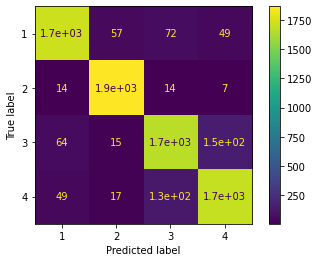

In [44]:
plot_confusion_matrix(LogReg_tfidf, X_test_tfidf, y_test);

In [45]:
accuracy_score(y_test, y_preds_LogReg_tfidf)

0.9156578947368421

#### MultiNomial Naive bayes

In [46]:
start = time.time()
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
end = time.time()
print("Training time for MultiNomial NB: ", (end-start), " secs")

Training time for MultiNomial NB:  0.06715726852416992  secs


In [47]:
y_preds_MNB_tfidf = nb_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_preds_MNB_tfidf))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.95      0.98      0.96      1900
           3       0.86      0.86      0.86      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



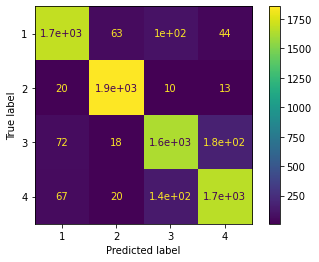

In [48]:
plot_confusion_matrix(nb_tfidf, X_test_tfidf, y_test);

In [49]:
accuracy_score(y_test, y_preds_MNB_tfidf)

0.900921052631579

>**Inferences**:
>* Even the sparse tfidf vectors produced a fairly good accuracy using Logistic and NaiveBayes classifiers.
* The training time for NavieBayes was shocking at the first looks. Need to investigate or analyse why it is so?



### Word2Vec

In [50]:
start = time.time()
doc_matrix_train_w2v = document_vectorizer(X_train,w2v,doc_action='tokenize')
end = time.time()
print("Time for document matrix generation: ", (end-start), " secs")

Time for document matrix generation:  13.711174488067627  secs


In [51]:
start = time.time()
doc_matrix_test_w2v = document_vectorizer(X_test,w2v,doc_action='tokenize')
end = time.time()
print("Time for document matrix generation: ", (end-start), " secs")

Time for document matrix generation:  0.8206722736358643  secs


#### Logistic Regression

In [52]:
start = time.time()
LogReg_w2v = LogisticRegression(max_iter=300)
LogReg_w2v.fit(doc_matrix_train_w2v, y_train)
end = time.time()
print("Training time for Logistic Regression: ", (end-start), " secs")

Training time for Logistic Regression:  49.832573890686035  secs


In [53]:
y_preds_LogReg_w2v = LogReg_w2v.predict(doc_matrix_test_w2v)
print(classification_report(y_test, y_preds_LogReg_w2v))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.95      0.96      0.96      1900
           3       0.86      0.85      0.85      1900
           4       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



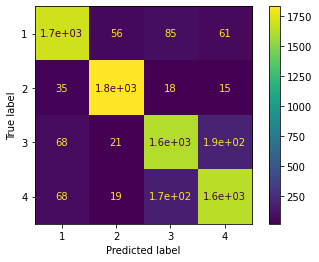

In [54]:
plot_confusion_matrix(LogReg_w2v, doc_matrix_test_w2v, y_test)

In [55]:
accuracy_score(y_test, y_preds_LogReg_w2v)

0.8939473684210526

In [56]:
start = time.time()
nb_w2v = MultinomialNB()
nb_w2v.fit(doc_matrix_train_w2v, y_train)
end = time.time()
print("Training time for Naive Bayes: ", (end-start), " secs")

ValueError: ignored

>**Inferences**:
>* The Multinomial NavieBayes will not accept negative values in the data. Need to research why is it so?



Lets now try some deep learning models before moving into transformers

#### LSTM

Will come back to LSTMs and transformers later.

## 6.Tuning the Best Model

Hyper parameter tuning yet to be performed.

## 7.Pickle the models for future use

In [57]:
import pickle

In [58]:
pickle.dump(LogReg_tfidf, open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/LogReg_tfidf.pkl', 'wb'))
pickle.dump(nb_tfidf, open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/nb_tfidf.pkl', 'wb'))
pickle.dump(LogReg_w2v, open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/LogReg_w2v.pkl', 'wb'))
pickle.dump(w2v, open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/w2v.pkl', 'wb'))
pickle.dump(tfidf_vec, open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/tfidf.pkl', 'wb'))

In [59]:
len(w2v.wv.vocab.keys())

82648

In [60]:
w2v_reloaded = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/w2v.pkl', 'rb'))
len(w2v_reloaded.wv.vocab.keys())

82648

In [61]:
len(tfidf_vec.vocabulary_)

56297

In [62]:
tfidf_vec_reload = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/tfidf.pkl', 'rb'))
len(tfidf_vec_reload.vocabulary_)

56297

In [63]:
LogReg_tfidf_reload = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Data/AGNews/saved_models/LogReg_tfidf.pkl', 'rb'))

In [64]:
y_preds_reload = LogReg_tfidf_reload.predict(X_test_tfidf)
accuracy_score(y_test,y_preds_reload)

0.9156578947368421

## 8.Predictions

In [129]:
def predict_news_type(headline, short_desc, vec, model, embedType='w2v', lemmatize=True):
  """
  Takes the headline, short description, vectorizer, model and embedding type as input.
  Then predicts the type of the news article among ['World', 'Sports', 'Business', 'Sci/Tech'].
  """
  clubbed_article = headline + " " + short_desc
  clean_clubbed_article = clean_corpus(clubbed_article)
  if embedType.lower() == 'tfidf':
    article_embed = vec.transform(clean_clubbed_article)
  elif embedType.lower() == 'w2v':
    clubbed_article_list = []
    clubbed_article_list.append(clean_clubbed_article)
    article_embed = document_vectorizer(clubbed_article_list, vec, doc_action='tokenize', lemmatize=lemmatize)
  else:
    raise NameError("Invalid 'embedType' specified.")
  y_pred = model.predict_proba(article_embed.reshape(1,-1))
  pos = np.argmax(y_pred)
  label = labels[pos]
  print("Article Type: " + label  + ", Confidence: " + str(round((y_pred[0][pos])*100, 2)) + "%")
  return y_pred

In [136]:
Headline1 = '''Tsunami confirmed by Australian agency after magnitude earthquake in South Pacific'''
Desc1 = '''A the Australian weather agency confirmed. Tsunami confirmed the Australian Bureau of Meteorology said in a tweet, as it warned of a marine threat to Lord Howe Island. Tsunami affecting marine area commencing after am AEDT Thu, persisting for several hours the tweet read.'''
pred1 = predict_news_type(headline=Headline1, short_desc=Desc1, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: World, Confidence: 91.1%


In [137]:
Headline2 = '''1st video of Mars captured by Chinese spacecraft in orbit released'''
Desc2 = '''China's space agency released the first video of Mars recorded from its spacecraft Tianwen-1 on Friday, two days after it entered the planet's orbit. The video shows the surface of the planet coming into view out of a pitch black sky, and white craters are also visible. Tianwen-1 is expected to touch down on the planet's surface in May.'''
pred2 = predict_news_type(headline=Headline2, short_desc=Desc2, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: Sci/Tech, Confidence: 99.83%


In [138]:
Headline3 = '''Wasn't an easy decision: Root on dropping Dom Bess for 2nd Test'''
Desc3 = '''Talking about the changes in the playing XI for the second Test, England Test captain Joe Root said the decision to drop all-rounder Dom Bess wasn't easy but the 23-year-old needs to work on consistency. "This gives Moeen Ali a great opportunity to come back into things," Root added. Bess scored 59 runs and picked five wickets in first Test.'''
pred3 = predict_news_type(headline=Headline3, short_desc=Desc3, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: Sports, Confidence: 72.91%


In [139]:
Headline4 = '''Tesla CEO Elon Musk told Joe Rogan that he is trying to figure how to make Tesla Roadster electric car hover without killing people. "Maybe it can hover like a meter above the ground...If you plummet it'll blow out the suspension but you're not gonna die," he added. Musk said Tesla is "finishing the engineering of the Roadster this year".'''
Desc4 = '''Talking about the changes in the playing XI for the second Test, England Test captain Joe Root said the decision to drop all-rounder Dom Bess wasn't easy but the 23-year-old needs to work on consistency. "This gives Moeen Ali a great opportunity to come back into things," Root added. Bess scored 59 runs and picked five wickets in first Test.'''
pred4 = predict_news_type(headline=Headline4, short_desc=Desc4, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: World, Confidence: 52.47%


In [141]:
Headline5 = '''He was referring to his family: Giriraj on Rahul's 'Hum do, hamare do' remark'''
Desc5 = '''After Congress leader Rahul Gandhi said that India is being run by four people with a motto of 'Hum do, hamare do', Union Minister Giriraj Singh said that he was referring to his family members. "He was referring to himself, his mother, his sister and his brother-in-law...Don't know what message he wants to give to the nation," Singh said.'''
pred5 = predict_news_type(headline=Headline5, short_desc=Desc5, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: World, Confidence: 82.77%


In [143]:
Headline6 = '''₹13k cr Delhi-Dehradun expressway to cut travel time to 2.5 hours: Gadkari'''
Desc6 = '''Union Transport Minister Nitin Gadkari on Thursday said that the Transport Ministry has approved the ₹13,000 crore Delhi-Dehradun expressway. Once completed, it will reduce the distance between the two cities from 235 to 210 kilometres and travel time from 6.5 to 2.5 hours, the ministry said. The expressway is expected to be operational within two years from now, it added.'''
pred6 = predict_news_type(headline=Headline6, short_desc=Desc6, vec=w2v_reloaded, model=LogReg_w2v, embedType='w2v')

Article Type: Business, Confidence: 76.41%


In [144]:
labels

['World', 'Sports', 'Business', 'Sci/Tech']